## Описание проекта
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

***Описание тарифов***

**Тариф «Смарт»**
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
* минута разговора: 3 рубля
* сообщение: 3 рубля
* 1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
* минута разговора: 1 рубль
* сообщение: 1 рубль
* 1 Гб интернет-трафика: 150 рублей

##  Описание данных
Таблица `users` (информация о пользователях):
* **user_id** — уникальный идентификатор пользователя
* **first_name** — имя пользователя
* **last_name** — фамилия пользователя
* **age** — возраст пользователя (годы)
* **reg_date** — дата подключения тарифа (день, месяц, год)
* **churn_date** — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* **city** — город проживания пользователя
* **tariff** — название тарифного плана

Таблица `calls` (информация о звонках):
* **id** — уникальный номер звонка
* **call_date** — дата звонка
* **duration** — длительность звонка в минутах
* **user_id** — идентификатор пользователя, сделавшего звонок

Таблица `messages` (информация о сообщениях):
* **id** — уникальный номер сообщения
* **message_date** — дата сообщения
* **user_id** — идентификатор пользователя, отправившего сообщение

Таблица `internet` (информация об интернет-сессиях):
* **id** — уникальный номер сессии
* **mb_used** — объём потраченного за сессию интернет-трафика (в мегабайтах)
* **session_date** — дата интернет-сессии
* **user_id** — идентификатор пользователя

Таблица `tariffs` (информация о тарифах):
* **tariff_name** — название тарифа
* **rub_monthly_fee** — ежемесячная абонентская плата в рублях
* **minutes_included** — количество минут разговора в месяц, включённых в абонентскую плату
* **messages_included** — количество сообщений в месяц, включённых в абонентскую плату
* **mb_per_month_included** — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* **rub_per_minute** — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* **rub_per_message** — стоимость отправки сообщения сверх тарифного пакета
* **rub_per_gb** — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Обзор данных

Импортируем библиотеки которые нам скорее всего понадобятся.

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import statistics
from scipy import stats as st
import seaborn as sns

In [3]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv', index_col=0)
messages = pd.read_csv('/datasets/messages.csv')
tariff = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

Далее изучим все файла методом инфо и дескрайб

In [4]:
def func(x):
    display(x.head(5))
    display(x.info())
    display(x.describe())
    display(x.duplicated().sum())
    display(x.isnull().sum())
    return x

In [5]:
print('Изучим данные о звонках')
print('___________________________')
func(calls)
print('Изучим данные об интернете')
print('___________________________')
func(internet)
print('Изучим данные о сообщениях')
print('___________________________')
func(messages)
print('Изучим данные о тарифах')
print('___________________________')
func(tariff)
print('Изучим данные о пользователях')
print('___________________________')
func(users)

Изучим данные о звонках
___________________________


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


0

id           0
call_date    0
duration     0
user_id      0
dtype: int64

Изучим данные об интернете
___________________________


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


None

,mb_used,user_id
count,149396.000000,149396.000000
mean,370.192426,1252.099842
std,278.300951,144.050823
min,0.000000,1000.000000
25%,138.187500,1130.000000
50%,348.015000,1251.000000
75%,559.552500,1380.000000
max,1724.830000,1499.000000


0

id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

Изучим данные о сообщениях
___________________________


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


0

id              0
message_date    0
user_id         0
dtype: int64

Изучим данные о тарифах
___________________________


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
std,671.751442,10861.160159,1767.766953,989.949494,35.355339,1.414214,1.414214
min,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
25%,287.500000,19200.000000,1125.000000,900.000000,162.500000,1.500000,1.500000
50%,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
75%,762.500000,26880.000000,2375.000000,1600.000000,187.500000,2.500000,2.500000
max,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000


0

messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
tariff_name              0
dtype: int64

Изучим данные о пользователях
___________________________


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


0

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


***вывод***:

Есть NaNы в churn_date но они нам не помешают поэтому не будем их трогать. Так же я заметил что даты указаны в типах объект,нам стоит их перевести в дататайм. В остальном в целом данные хорошие,их достаточно чтобы проверить гипотезы которые нам поставили в задаче,но для начала перейдет в предобработку данных.

## Предобработка данных

Переведём значения в дататайм и выделим от туда месяца,это нам пригодится в дальнейшем

### Звонки (calls)

In [6]:
calls['call_date'] = pd.to_datetime(calls['call_date']).astype('datetime64[D]')
calls['month'] = pd.to_datetime(calls['call_date']).dt.month

### Интернет (internet)

In [7]:
internet['session_date'] = pd.to_datetime(internet['session_date']).astype('datetime64[D]')
internet['month'] = pd.to_datetime(internet['session_date']).dt.month

###  Сообщения  (messages)

In [8]:
messages['message_date'] = pd.to_datetime(messages['message_date']).astype('datetime64[D]')
messages['month'] = pd.to_datetime(messages['message_date']).dt.month

###  Тариф  (tariffs)

In [9]:
tariff

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


###  Клиенты  (users)

In [10]:
users['reg_date'] = pd.to_datetime(users['reg_date']).astype('datetime64[D]')
users['month'] = pd.to_datetime(users['reg_date']).dt.month

Готово передвинемся к дальнейшим расчётам.

## Расчёты и добавление результатов в таблицу

На данном этапе я хочу создать отдельные таблицы для высчитывания нужных результатов для звонков,интернета,сообщения. Также в данном разделе буду переводить некоторые данные в другой тип данных.

In [11]:
calls['duration'] = np.ceil(calls['duration']).astype(int)
calls_all = calls.pivot_table(index=['user_id','month'],values='duration', aggfunc=['sum','count'])
calls_all.columns = ['duration_sum', 'duration_count']

In [31]:
internet_all = internet.pivot_table(index=['user_id','month'],values='mb_used', aggfunc=['sum'])
internet_all.columns = ['gb']
internet_all['gb'] = (internet_all['gb']/1024)
internet_all['gb'] = np.ceil(internet_all['gb']).astype(int)

In [32]:
messages_all = messages.pivot_table(index=['user_id','month'],values='message_date',aggfunc='count')
messages_all.columns = ['messages_count']
messages_all['messages_count'] = np.ceil(messages_all['messages_count']).astype(int)

1. Посчитали количество звонков и их сумму в минутах за месяц на каждого пользователя.
2. Посчитали количество гигабайт потраченых за месяц на каждого пользователя.
3. Посчитали количество сообщений отправленых за месяц на каждого пользователя.

Захотелось для удобства объеденить имя и фамилию

In [33]:
users['full_name'] = users['first_name'] + ' ' + users['last_name']
#users['full_name'] = users[['first_name', 'last_name']].agg(' '.join, axis=1)
users = users.drop(["first_name", "last_name"], axis=1)

В данном этапе буду соединять полученые результаты.

In [34]:
df = pd.merge(calls_all,messages_all,how='outer',on=['user_id','month'])
df = pd.merge(df,internet_all,how='outer',on=['user_id','month'])
df = pd.merge(df,users,how='outer',on=['user_id']).reset_index()
df

,index,user_id,duration_sum,duration_count,messages_count,gb,age,churn_date,city,reg_date,tariff,month,full_name
0,0,1000,159.0,22.0,22.0,3.0,52,NaN,Краснодар,2018-05-25,ultra,5,Рафаил Верещагин
1,1,1000,172.0,43.0,60.0,23.0,52,NaN,Краснодар,2018-05-25,ultra,5,Рафаил Верещагин
2,2,1000,340.0,47.0,75.0,14.0,52,NaN,Краснодар,2018-05-25,ultra,5,Рафаил Верещагин
3,3,1000,408.0,52.0,81.0,14.0,52,NaN,Краснодар,2018-05-25,ultra,5,Рафаил Верещагин
4,4,1000,466.0,58.0,57.0,15.0,52,NaN,Краснодар,2018-05-25,ultra,5,Рафаил Верещагин
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,3211,1489,NaN,NaN,21.0,20.0,35,NaN,Санкт-Петербург,2018-08-15,smart,8,Павел Гончаров
3212,3212,1489,NaN,NaN,20.0,18.0,35,NaN,Санкт-Петербург,2018-08-15,smart,8,Павел Гончаров
3213,3213,1489,NaN,NaN,35.0,17.0,35,NaN,Санкт-Петербург,2018-08-15,smart,8,Павел Гончаров
3214,3214,1128,NaN,NaN,NaN,NaN,51,2018-12-23,Волжский,2018-12-15,ultra,12,Ксения Агаева


Появились пропущеные значения в сообщения и в других, видимо в связи с тем что не все пользуются или интернетом или не все отправляют сообщения. Это моё предположение. Заполним 0 значением. Пригодится для дальнейших вычеслений.

In [35]:
df['duration_sum'] = df['duration_sum'].fillna(0).astype(int)
df['duration_count'] = df['duration_count'].fillna(0).astype(int)
df['messages_count'] = df['messages_count'].fillna(0)
df['gb'] = df['gb'].fillna(0).round(0)
df

,index,user_id,duration_sum,duration_count,messages_count,gb,age,churn_date,city,reg_date,tariff,month,full_name
0,0,1000,159,22,22.0,3.0,52,NaN,Краснодар,2018-05-25,ultra,5,Рафаил Верещагин
1,1,1000,172,43,60.0,23.0,52,NaN,Краснодар,2018-05-25,ultra,5,Рафаил Верещагин
2,2,1000,340,47,75.0,14.0,52,NaN,Краснодар,2018-05-25,ultra,5,Рафаил Верещагин
3,3,1000,408,52,81.0,14.0,52,NaN,Краснодар,2018-05-25,ultra,5,Рафаил Верещагин
4,4,1000,466,58,57.0,15.0,52,NaN,Краснодар,2018-05-25,ultra,5,Рафаил Верещагин
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,3211,1489,0,0,21.0,20.0,35,NaN,Санкт-Петербург,2018-08-15,smart,8,Павел Гончаров
3212,3212,1489,0,0,20.0,18.0,35,NaN,Санкт-Петербург,2018-08-15,smart,8,Павел Гончаров
3213,3213,1489,0,0,35.0,17.0,35,NaN,Санкт-Петербург,2018-08-15,smart,8,Павел Гончаров
3214,3214,1128,0,0,0.0,0.0,51,2018-12-23,Волжский,2018-12-15,ultra,12,Ксения Агаева


**Формула для выручки компании «Мегалайн»**

In [36]:
def profit_calc(row):
    if row['tariff'] == 'ultra':
        tariff = ultra
    elif row['tariff'] == 'smart':
        tariff = smart
    profit = (tariff['rub_monthly_fee'] + tariff['rub_per_minute'] * np.maximum(0, (row['duration_sum'] - tariff['minutes_included']))
              + tariff['rub_per_message'] * np.maximum(0, (row['messages_count'] - tariff['messages_included']))
              + tariff['rub_per_gb'] * np.maximum(0, (row['gb'] - tariff['mb_per_month_included'] / 1024))
             )
    return profit
ultra = tariff[tariff['tariff_name'] == 'ultra'].reset_index()
smart = tariff[tariff['tariff_name'] == 'smart'].reset_index()

In [37]:
df['profit'] = df.apply(profit_calc, axis=1)

так же удалю столбец churn_date не пригодится в расчётах

In [38]:
df = df.drop(["churn_date"],axis=1)

## Проанализируйте данные
Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

создам отдельно ДФку для отдельных тарифных планов

In [39]:
df_tariff_ultra = df[df['tariff'] == 'ultra']
df_tariff_smart = df[df['tariff'] == 'smart']

In [40]:
df.head(5)

,index,user_id,duration_sum,duration_count,messages_count,gb,age,city,reg_date,tariff,month,full_name,profit
0,0,1000,159,22,22.0,3.0,52,Краснодар,2018-05-25,ultra,5,Рафаил Верещагин,1950.0
1,1,1000,172,43,60.0,23.0,52,Краснодар,2018-05-25,ultra,5,Рафаил Верещагин,1950.0
2,2,1000,340,47,75.0,14.0,52,Краснодар,2018-05-25,ultra,5,Рафаил Верещагин,1950.0
3,3,1000,408,52,81.0,14.0,52,Краснодар,2018-05-25,ultra,5,Рафаил Верещагин,1950.0
4,4,1000,466,58,57.0,15.0,52,Краснодар,2018-05-25,ultra,5,Рафаил Верещагин,1950.0


Text(0.5, 1.0, 'Сравнение звонков тарифов')

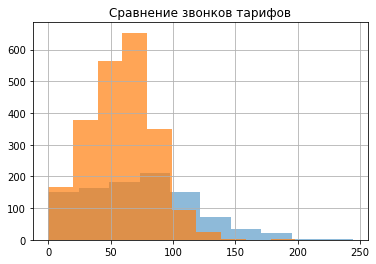

In [41]:
df_tariff_ultra['duration_count'].hist(bins=10, alpha=0.5)
df_tariff_smart['duration_count'].hist(bins=10, alpha=0.7).set_title('Сравнение звонков тарифов')

**Тут мы можем заметить что в тарифе смарт меньше звонят чем тарифе в ультра.**

Text(0.5, 1.0, 'Сравнение Гигов тарифов')

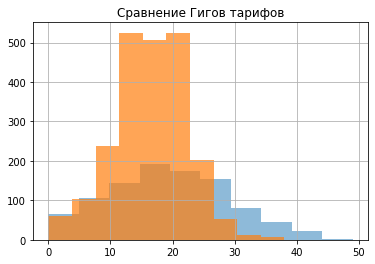

In [42]:
df_tariff_ultra['gb'].hist(bins=10, alpha=0.5)
df_tariff_smart['gb'].hist(bins=10, alpha=0.7).set_title('Сравнение Гигов тарифов')

**Гигабайт использует соответственно больше так же люди с тарифом ультра.**

Text(0.5, 1.0, 'Сравнение сообщений тарифов')

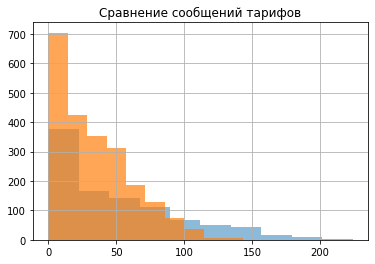

In [43]:
df_tariff_ultra['messages_count'].hist(bins=10, alpha=0.5)
df_tariff_smart['messages_count'].hist(bins=10,histtype='bar', alpha=0.7).set_title('Сравнение сообщений тарифов')

**Проанализиров данные мы видим что данный тарифный план ультра превосходит тарифный план смарт по количеству звонков/интернет трафика/сообщений.**

Количество переплат по тарифу смарт: 1662
Сумма переплат по тарифу смарт: 2563501.0


Text(0.5, 1.0, 'Переплата по тарифу смарт')

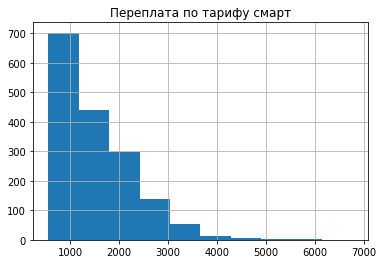

In [44]:
print('Количество переплат по тарифу смарт:',df_tariff_smart['profit'][df_tariff_smart['profit'] > 550].count())
print('Сумма переплат по тарифу смарт:',df_tariff_smart['profit'][df_tariff_smart['profit'] > 550].sum())
df_tariff_smart['profit'][df_tariff_smart['profit'] > 550].hist(bins=10).set_title('Переплата по тарифу смарт')

Количество  переплат по тарифу ультра: 134
Сумма переплат по тарифу ультра: 379650.0


Text(0.5, 1.0, 'Переплата по тарифу смарт')

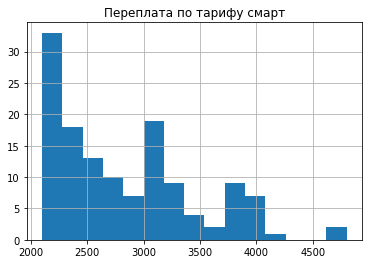

In [45]:
print('Количество  переплат по тарифу ультра:',df_tariff_ultra['profit'][df_tariff_ultra['profit'] > 1950].count())
print('Сумма переплат по тарифу ультра:',df_tariff_ultra['profit'][df_tariff_ultra['profit'] > 1950].sum())
df_tariff_ultra['profit'][df_tariff_ultra['profit'] > 1950].hist(bins=15).set_title('Переплата по тарифу смарт')

In [46]:
df_diffrent = (df_tariff_smart['profit'][df_tariff_smart['profit'] > 550].sum()) - (df_tariff_ultra['profit'][df_tariff_ultra['profit'] > 1950].sum())
df_diffrent

2183851.0

**Мы видим что чаще переплачивают по тарифу смарт чем ультра! Разница переплат составляет аж 2183851 р.**

In [47]:
print(f'Дисперсия по звонкам тарифа смарт: {np.var(df_tariff_smart.duration_count)}')
print(f'Дисперсия по звонкам тарифа ультра: {np.var(df_tariff_ultra.duration_count)}')
print(' ')
print(f'Дисперсия по интернет трафику тарифа смарт: {np.var(df_tariff_smart.gb)}')
print(f'Дисперсия по интернет трафику тарифа ультра: {np.var(df_tariff_ultra.gb)}')

print(' ')
print(f'Дисперсия по сообщениям тарифа смарт: {np.var(df_tariff_smart.messages_count)}')
print(f'Дисперсия по сообщениям тарифа ультра: {np.var(df_tariff_ultra.messages_count)}')

Дисперсия по звонкам тарифа смарт: 673.8048030324358
Дисперсия по звонкам тарифа ультра: 1930.2352982320435
 
Дисперсия по интернет трафику тарифа смарт: 33.11859498481772
Дисперсия по интернет трафику тарифа ультра: 97.27978308900676
 
Дисперсия по сообщениям тарифа смарт: 796.5978766916688
Дисперсия по сообщениям тарифа ультра: 2283.0995570851965


По дисперсию можно сказать что наша выборка имеет большой разброс от  среднего значения. Помотрим на среднее отклонение.

In [48]:
print('Тариф ультра')
print(' ')
print(f'Стандартное отклонение по звонкам тарифа ультра: {np.std(df_tariff_ultra.duration_count)}')
print(f'Стандартное отклонение по звонкам тарифа смарт: {np.std(df_tariff_smart.duration_count)}')
print(' ')
print(f'Стандартное отклонение по интернет трафику тарифа ультра: {np.std(df_tariff_ultra.gb)}')
print(f'Cтандартное отклонение по интернет трафику тарифа смарт: {np.std(df_tariff_smart.gb)}')
print(' ')
print(f'Стандартное отклонение по сообщениям тарифа ультра: {np.std(df_tariff_ultra.messages_count)}')
print(f'Стандартное отклонение по сообщениям тарифа смарт: {np.std(df_tariff_smart.messages_count)}')

Тариф ультра
 
Стандартное отклонение по звонкам тарифа ультра: 43.934443187914006
Стандартное отклонение по звонкам тарифа смарт: 25.95775034613816
 
Стандартное отклонение по интернет трафику тарифа ультра: 9.863051408616238
Cтандартное отклонение по интернет трафику тарифа смарт: 5.754875757548352
 
Стандартное отклонение по сообщениям тарифа ультра: 47.781791061922284
Стандартное отклонение по сообщениям тарифа смарт: 28.224065559229217


Стандартное отклонение лучше ,но также высока. И так же посмотрим на среднее значение

In [49]:
print(f'Среднее значение по звонкам тарифа ультра: {np.mean(df_tariff_ultra.duration_count)}')
print(f'Среднее значение по звонкам тарифа смарт: {np.mean(df_tariff_smart.duration_count)}')
print(' ')
print(f'Среднее значение по интернет трафику тарифа ультра: {np.mean(df_tariff_ultra.gb)}')
print(f'Среднее значение по интернет трафику тарифа смарт: {np.mean(df_tariff_smart.gb)}')
print(' ')
print(f'Среднее значение по сообщениям тарифа ультра: {np.mean(df_tariff_ultra.messages_count)}')
print(f'Среднее значение по сообщениям тарифа смарт: {np.mean(df_tariff_smart.messages_count)}')

Среднее значение по звонкам тарифа ультра: 73.3184584178499
Среднее значение по звонкам тарифа смарт: 58.437219730941706
 
Среднее значение по интернет трафику тарифа ультра: 19.474645030425965
Среднее значение по интернет трафику тарифа смарт: 16.32152466367713
 
Среднее значение по сообщениям тарифа ультра: 49.31338742393509
Среднее значение по сообщениям тарифа смарт: 33.36905829596412


## Проверьте гипотезы
* средняя выручка пользователей тарифов «Ультра» и «Смарт» не различаются;
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Поясните:
как вы формулировали нулевую и альтернативную гипотезы;
какой критерий использовали для проверки гипотез и почему.

Text(0.5, 1.0, 'Выручка тарифов')

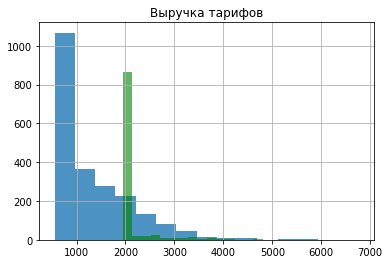

In [50]:
df_tariff_smart['profit'].hist(bins=15,alpha=0.8,grid=True)
df_tariff_ultra['profit'].hist(bins=15,alpha=0.6,color='green',grid=True).set_title('Выручка тарифов')

График особой информативности не даёт,единственное показывает что тариф за 550 выбирают больше людей чем ультра. Так же посмотрим выручку по отдельным тарифам и приступим к проверке гипотезы
* средняя выручка пользователей тарифов «Ультра» и «Смарт» не различаются;

In [51]:
print(f'Выручка тарифа смарт составляет: {df_tariff_smart.profit.sum()}')
print(f'Выручка тарифа ультра составляет: {df_tariff_ultra.profit.sum()}')

Выручка тарифа смарт составляет: 2875901.0
Выручка тарифа ультра составляет: 2041050.0


In [52]:
print(df_tariff_smart.profit.mean())
print(df_tariff_ultra.profit.mean())

1289.6417040358745
2070.030425963489


**Проверим гипотезы о равенстве среднего двух генеральных совокупностей по взятым выборкам тарифа смарт и ультра.**

Тарифы разные по ценнообразованию,поэтому нам стоит проверить важную гипотезу о выручке данных тарифов.

Нулевая гипотеза: средняя выручка по тарифам Смарт и Ультра не различаются;

Альтернативная гипотеза: средняя выручка по тарифам Смарт и Ультра различаются.

In [53]:
alpha = .01 # критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу

results = st.ttest_ind(
    df_tariff_smart['profit'], 
    df_tariff_ultra['profit'],equal_var = False) # разные по объему выборки правильно ли использовать equal_var?

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу о том что выручка тарифов не отличается")
else:
    print("Не получилось отвергнуть нулевую гипотезу о том что выручка тарифов отличается") 

p-значение: 1.927011394420941e-250
Отвергаем нулевую гипотезу о том что выручка тарифов не отличается


Выручка тарифов отличается! Принимаем альтернативную гипотезу.

Сейчас будем проверять гипотезу по отдельным городам. И для начала разделим Москву и другие города.

In [54]:
df_moscow_profit = df[df['city'] == 'Москва']
df_another_profit = df[df['city'] != 'Москва']
df_another_profit['city'].unique()

array(['Краснодар', 'Стерлитамак', 'Новокузнецк', 'Набережные Челны',
       'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень', 'Самара',
       'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа', 'Томск',
       'Чита', 'Мурманск', 'Петрозаводск', 'Тверь', 'Екатеринбург',
       'Махачкала', 'Вологда', 'Череповец', 'Ярославль', 'Сочи',
       'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула', 'Саратов',
       'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск', 'Калуга', 'Якутск',
       'Астрахань', 'Химки', 'Владикавказ', 'Волгоград', 'Саранск',
       'Ижевск', 'Новосибирск', 'Брянск', 'Тольятти', 'Нижний Тагил',
       'Орёл', 'Белгород', 'Воронеж', 'Курган', 'Барнаул', 'Красноярск',
       'Архангельск', 'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза',
       'Волжский', 'Магнитогорск', 'Нижний Новгород', 'Кострома',
       'Владивосток', 'Тамбов', 'Балашиха', 'Севастополь', 'Калининград',
       'Оренбург', 'Смоленск', 'Нижневартовск', 'Владимир',
       'Новороссийск', 'Гроз

<AxesSubplot:>

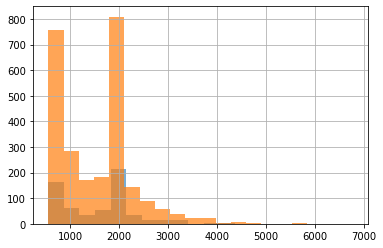

In [55]:
df_moscow_profit['profit'].hist(bins=15,alpha=0.6)
df_another_profit['profit'].hist(bins=20,alpha=0.7)

По графику видно что другие города опережают Москву. Так ли это? Давайте разделим количество городов на общую выручку и проверим сколько в среднем приносит доход город.

In [56]:
df_moscow_profit_sum = df_moscow_profit['profit'].sum()
df_another_profit_sum = (df_another_profit['profit'].sum()/ 75)
print(f'Выручка в Москве составляет: {df_moscow_profit_sum}')
print(f'Выручка каждого города средняя: {df_another_profit_sum}')

Выручка в Москве составляет: 945042.0
Выручка каждого города средняя: 52958.78666666667


**Проверим гипотезы о равенстве среднего двух генеральных совокупностей по взятым выборкам тарифа смарт и ультра.**

Моё предположение,что в Москве живёт больше людей,а значит чаще покупают данные тарифы чем в других регионах. На основе этой догадки сформируем гипотезы так.

Нулевая гипотеза: Средняя выручка в Москве и регионах не различаются;

Альтернативная гипотеза: Средняя выручка в Москве и регионах отличаются.

In [57]:
alpha = .01 # критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу

results = st.ttest_ind(
    df_moscow_profit['profit'], 
    df_another_profit['profit'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("принимаем альтернативную гипотезу о том что cредняя выручка в Москве и регионах отличаются")
else:
    print("принимаем нулевую гипотезу о том что средняя выручка в Москве и регионах не различаются") 

p-значение: 0.5400751614511182
принимаем нулевую гипотезу о том что средняя выручка в Москве и регионах не различаются


Данный тест нам показал что мы принимаем нулевую гипотезу: о том что, средняя выручка Москвы не различаются от других регионов.

### Итоговый вывод:

1. Тарифный план Ультра.

**Меньше людей Используют данный тариф. Данный тарифный план приносит меньше выручки с переплаты. Его меньше используют. По данному тарифу отправляют также меньше смс/звонят/используют интернет трафик. Общий доход с данного тарифа составляет - `2041050` рублей за год**

2. Тарифный план Смарт.

**Данный тарифный план используют люди чаще чем ультра. Так же по данному тарифу могу сказать что люди чаще звонят/отправляют смс/используют интернет трафик. Особенность данного тарифа является что люди переплачивают примерно на 2183851 больше чем на тарифе смарт. Тем самым подтверждая что доходность с данного тарифа выше. Выручка данного тарифа за год составляет - `2875901` р. за год**

3. Гипотезы.

**Мы проверили две гипотезы о равенстве среднего двух генеральных совокупностей по взятым нами выборкам.**

* В первом вопросе подтвердилась Альтернативная гипотеза: средняя выручка по тарифам Смарт и Ультра различаются. По анализу выше мы видим что тариф смарт принёс нам больше прибыли.

* Во втором вопросе подтвердилась Нулевая гипотеза: средняя выручка пользователей из Москвы не различаются от выручки пользователей из других регионов.

4. Лучшим показателем является тариф Смарт для компании 'Мегалайн '.